<a href="https://colab.research.google.com/github/japerego/DroidCafe/blob/master/Proyecto_3_1_Clasificador_Binario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- *Alumno*:
- *Asignatura*: Ingeniería del Conocimiento
- *Curso*: 2021/2022
- *Profesor*: Fco. Javier Martínez de Pisón
- Universidad de La Rioja

# Proyecto 3. Parte 1. Diseño de DSS en Empresa de Ventas On-Line: Clasificador Binario de la Clase 2

Vamos a desarrollar clasificadores trabajando con la base de datos de la competicion de Kaggle [Otto Group Product Classification](https://www.kaggle.com/c/otto-group-product-classification-challenge).

Otto Group es una de las mayores multinacionales de venta de comercio electrónico con empresas subsidiarias en más de 20 países del mundo. Cada día, venden millones de productos por todo el mundo incrementando continuamente la oferta con miles de productos nuevos.

Debido a la enorme cantidad de productos que se incluyen diariamente, **la empresa necesita tener un buen modelo predictivo que le ayude a clasificar cada nuevo producto en nueve grandes grupos**. Este modelo permitirá a la empresa ser mucho más eficiente en la realización de futuros trabajos como: análisis de mercado, análisis de clientes, diseño de ofertas, análisis de ventas, etc.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4280/media/Grafik.jpg)

En este proyecto vamos a aprender a desarrollar modelos clasificadores útiles para la toma de decisiones empresariales. En particular, el objetivo es buscar buenos modelos clasificadores capaces de identificar ante un nuevo producto y una serie de características que lo describe, **a qué familia pertenece**.

Primero desarrollaremos modelos binarios y después modelos multiclase. A aprenderemos cómo realizar el ajuste de los hiperparámetros de modelos y combinarlos en modelos *Ensemble*.

In [1]:
!pip install bayesian-optimization
!pip install lightgbm
!pip install xgboost

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=63d376468101c5d5c7fe3c994ba22d42882cb7ffa5869ba06776c9e6db85ff5e
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
# Importamos paquetes basicos
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.metrics import log_loss, cohen_kappa_score, accuracy_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from bayes_opt import BayesianOptimization

from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# %matplotlib inline
plt.style.use('ggplot')
# Elimina la limitación en visualización del numero de columnas
pd.set_option('display.max_columns', None) 

## Cargamos la Base de Datos

In [3]:
!wget https://github.com/IC1920/Datasets/raw/master/train.zip -O train.zip
!wget https://github.com/IC1920/Datasets/raw/master/test.zip -O test.zip
!unzip -o train.zip
!unzip -o test.zip

--2022-05-12 15:14:01--  https://github.com/IC1920/Datasets/raw/master/train.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip [following]
--2022-05-12 15:14:02--  https://raw.githubusercontent.com/IC1920/Datasets/master/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1655239 (1.6M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   1.58M  --.-KB/s    in 0.04s   

2022-05-12 15:14:02 (39.9 MB/s) - ‘train.zip’ saved [1655239/1655239]

--2022-05-12 15:14:02--  https://github.com/IC1920/Datasets/raw/master/test.zip

Para reducir los tiempos de entrenamiento y, por fines didácticos, **vamos a crear tres bases de datos a partir de la base de datos de entrenamiento original**: una de entrenamiento, otra de validación para ajustar los hiperparámetros y una final de testeo para verificar el grado de generalización del modelo elegido. Las mismas se van a realizar mediante muestreo estratificado. Lo ideal sería utilizar un alto porcentaje de la BD para entrenar (por ejemplo un 80%) o usar validación cruzada (incluso repetida), pero para acelerar el proceso de entrenamiento vamos a reducir el tamaño de la base de datos de entrenamiento. Es posible que los modelos mejoren si se entrenan con más datos...

La base de datos original está disponible en https://www.kaggle.com/c/otto-group-product-classification-challenge, con más de 65.000 instancias. Es importante destacar que las variables han sido anonimizadas por la empresa y no se dispone de su descripción real. 


In [4]:
# Leemos los archivos 
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape, df_test.shape)

features = ['feat_'+str(i) for i in np.arange(1,94)]
target = 'target'

(61878, 95) (144368, 94)


In [5]:
df_train.columns

Index(['id', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54',
       'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60',
       'feat_61', 'feat_62', 'feat_63', 'feat_64', 'feat_65', 'feat_66',
       'feat_67', 'feat_68', 'feat_69', 'feat_70', 'feat_71', 'feat_72',
       'feat_73', 'feat_74', 'feat_75', 'feat_76', 'feat_77', 'feat_78',
       'feat_79', 'feat_80', 'feat_81', 'feat_82', 'fe

In [6]:
# Realizamos un Muestreo Estratificado
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# Convertimos a números las clases (0 a 8)
df_train['target_num'] = df_train['target'].map(dict(zip(df_train.target.unique(),np.arange(len(df_train.target.unique())))))
df_train['kfold'] = 0
for nfold, (_, fold_index) in enumerate(skf.split(df_train, df_train.target)):
    df_train.loc[fold_index, 'kfold'] = nfold

df_train_reduc = df_train[df_train['kfold']<4].reset_index(drop=True)    
df_valid_reduc = df_train[df_train['kfold'].isin([4,5,6])].reset_index(drop=True)
df_test_reduc = df_train[df_train['kfold']>6].reset_index(drop=True)
print(df_train_reduc.shape, df_valid_reduc.shape, df_test_reduc.shape)

(24752, 97) (18564, 97) (18562, 97)


## AED

La base de datos está anonimizada por la empresa y ya preprocesada por lo que realizaremos un AED muy sencillo.

In [ ]:
df_train_reduc.sample(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target,target_num,kfold
8165,20409,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,Class_3,2,1
5725,14325,0,0,0,0,0,0,0,0,1,0,0,0,0,4,2,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,0,0,1,0,3,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,11,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,Class_2,1,0
19756,49383,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Class_8,7,0
17890,44721,0,0,25,5,0,1,0,0,0,0,5,0,1,0,0,2,0,0,0,0,1,1,0,0,0,0,9,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,4,0,9,0,0,1,0,0,0,0,23,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,Class_6,5,3
3022,7585,0,0,0,0,0,0,0,1,0,0,0,0,0,3,1,9,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,1,2,0,0,2,1,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,1,0,Class_2,1,0


In [ ]:
np.unique(df_train.dtypes,return_counts=True)

(array([dtype('int64'), dtype('O')], dtype=object), array([96,  1]))

Tenemos, además del 'id' de cada producto, 93 características anónimas del tipo entero 64. Según la descripción de Kaggle los atributos representan el conteo de diferentes eventos.

El *target*, representa 9 clases con la siguiente distribución (la base de datos de testeo lógicamente no tiene *target*).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


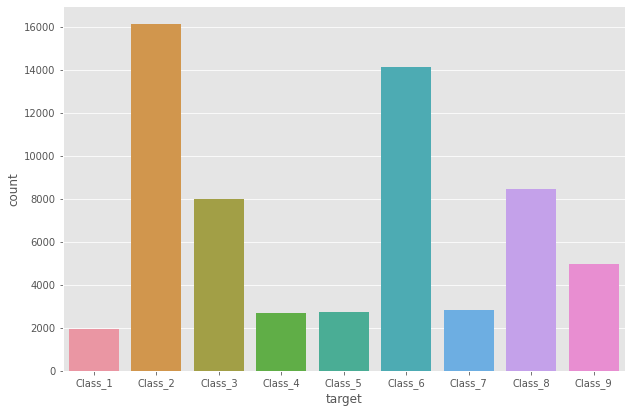

In [ ]:
g = sns.catplot('target',data=df_train,kind="count")
g.fig.set_size_inches(10,6)
# df_train['target'].value_counts()

In [ ]:
df_test.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,3,2,1,0,0,0,0,0,0,0,5,3,1,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,0,4,0,4,0,0,0,0,2,0,0,0,8,0,0,0,0,0,0,0,0,2,0,4,0,4,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,6,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,4,0,2,0,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,0,7,1,0,0,0,7,0,2,0,0,0,4,0,0,0,1,1,2,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,1,0,4,0,2,3,0,0,0,0,10,1,0,2,0,0,1,6,1,1,0,0,1,1,1,2,0,0,2,0,0,0,0,0,0,0,6,0,2,0,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,21,3,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,9,0,0,2,0,0,0,0,6,0,8,0,0,0,0,1,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,0,5,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,9,0,0


Tanto en la base de datos de testeo como la de entrenamiento vemos que los valores son muy dispersos (sparse), con un elevado número de ceros.

In [7]:
np.unique(df_train[features].values.flatten(),return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 119, 121, 123, 125, 127, 130, 131, 132, 137, 139, 145, 148,
        149, 158, 160, 161, 165, 170, 171, 172, 180, 181, 231, 252, 253,
        263, 281, 283, 287, 311, 323, 325, 352]),
 array([4565838,  595789,  227816,  106951,   66006,   40568,   30343,
          22321,   17639,   13326,   11271,    8394,    7670,    5740,
     

Visualizamos en un boxplot cada feature según las clases de salida. En este caso, fijamos el limite superior a 15 para ver con más detenimiento los diagramas de cajas.

  0%|          | 0/93 [00:00<?, ?it/s]

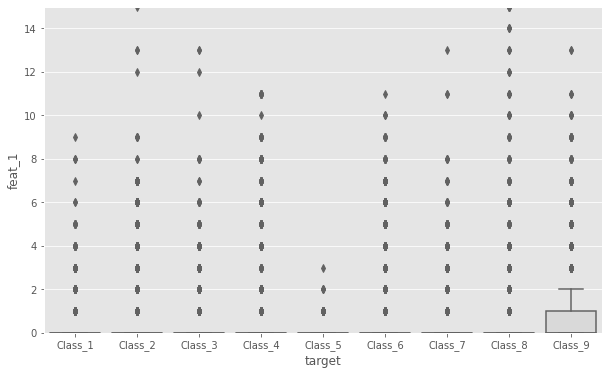

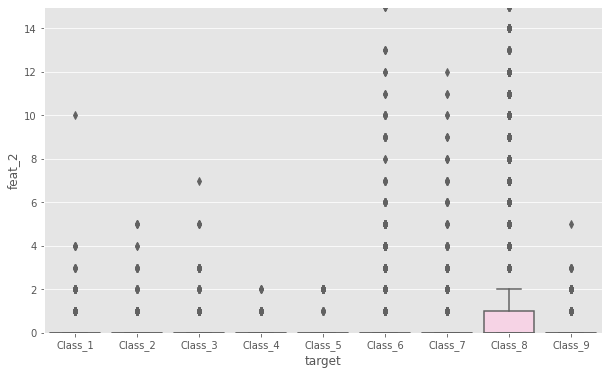

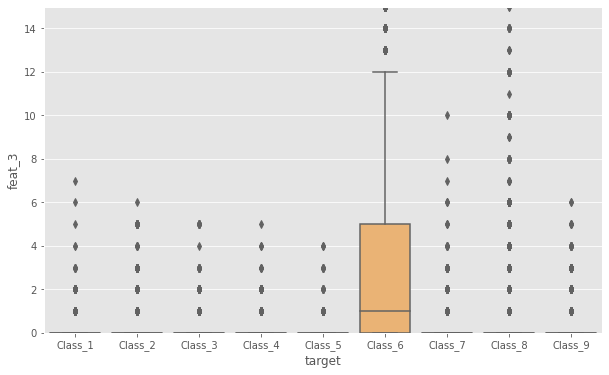

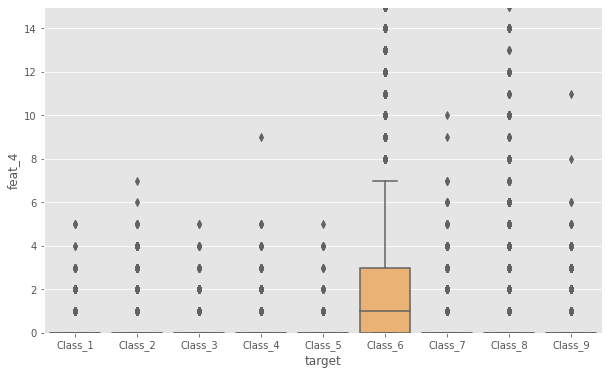

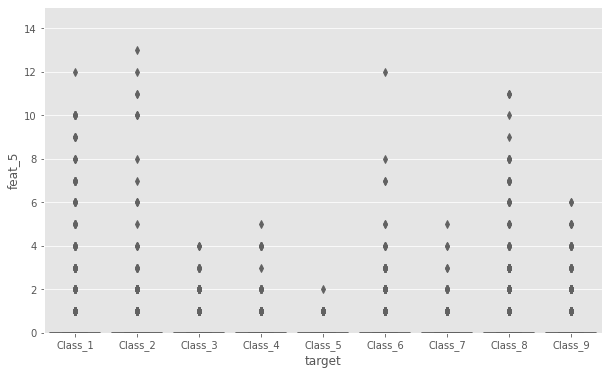

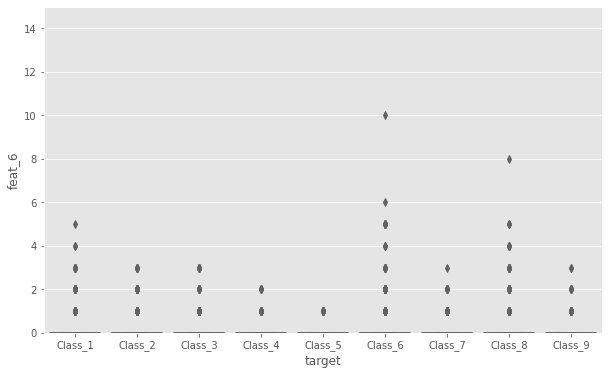

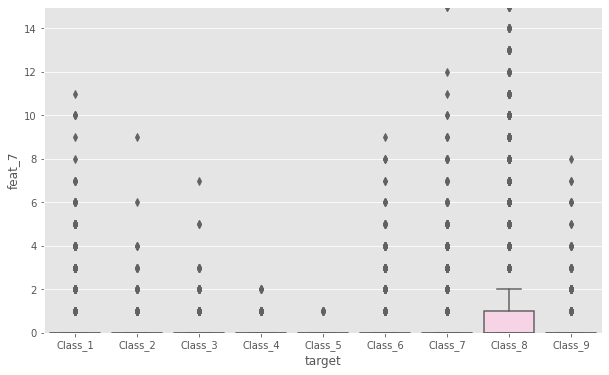

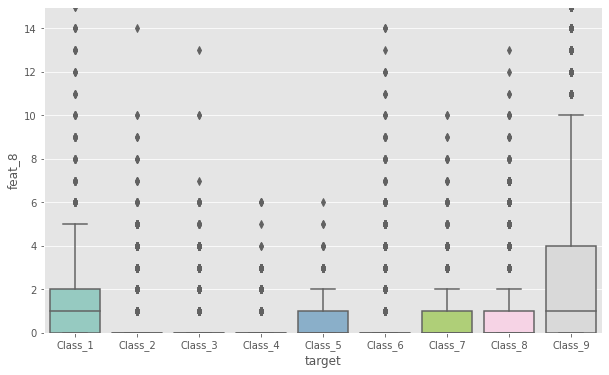

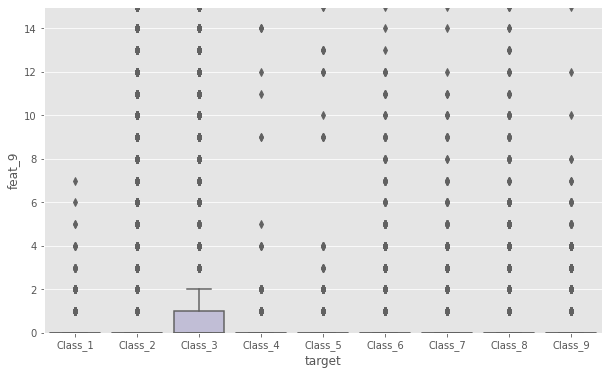

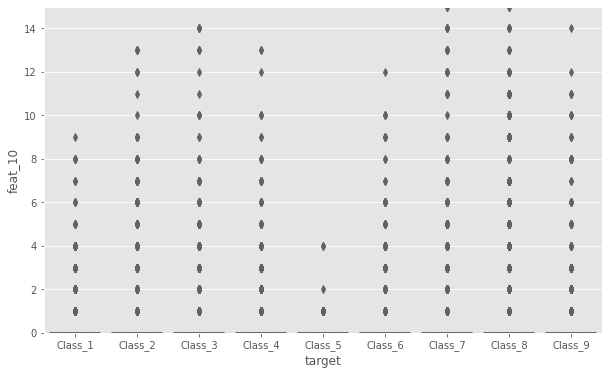

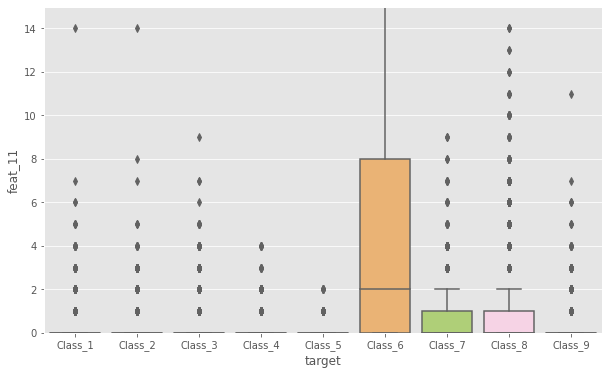

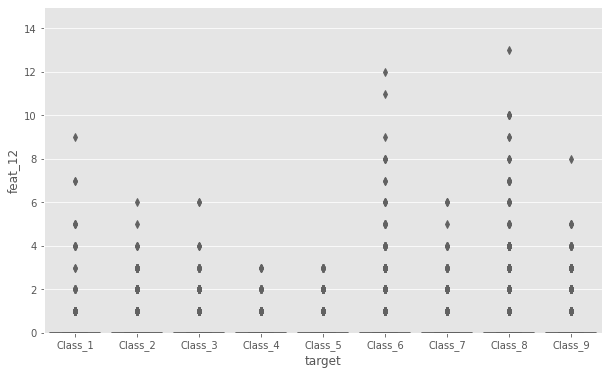

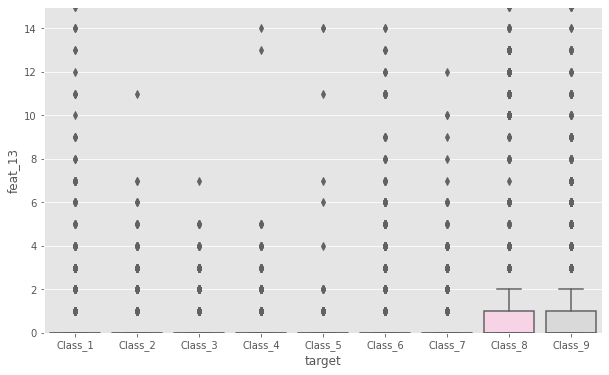

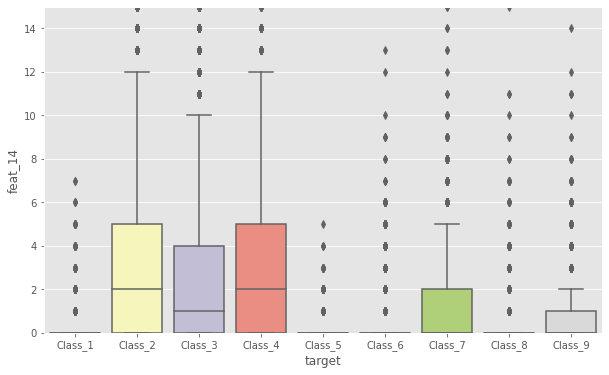

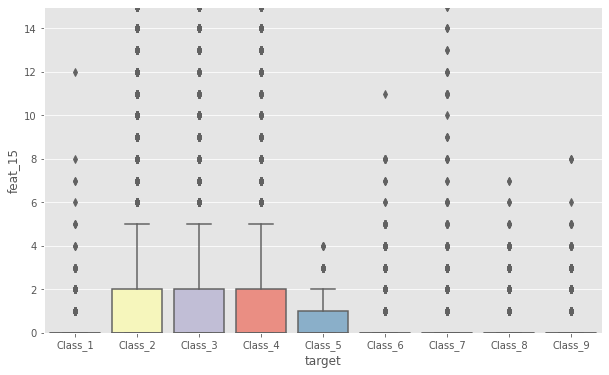

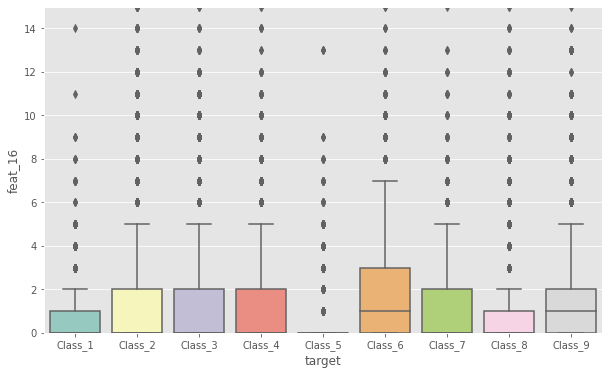

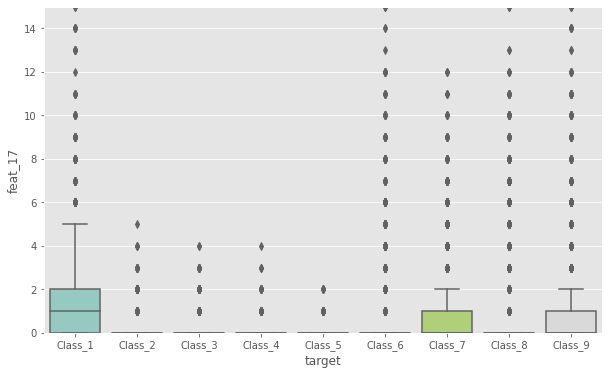

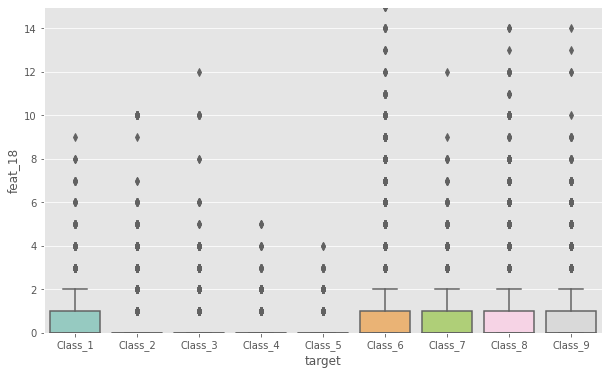

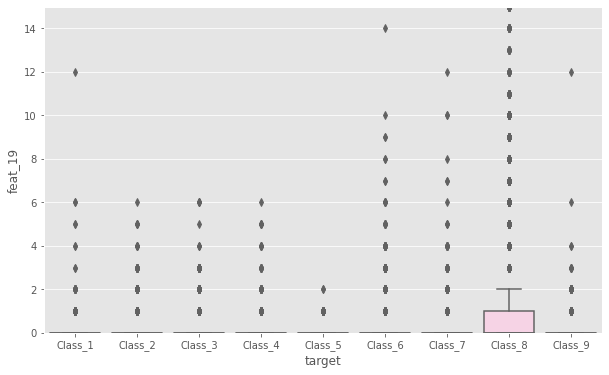

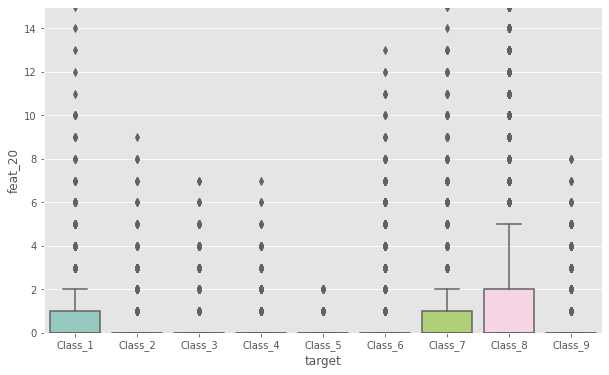

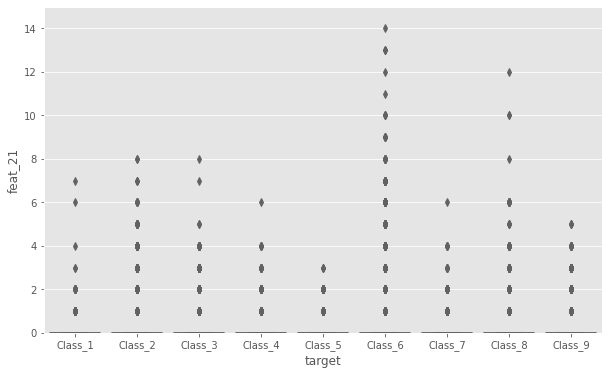

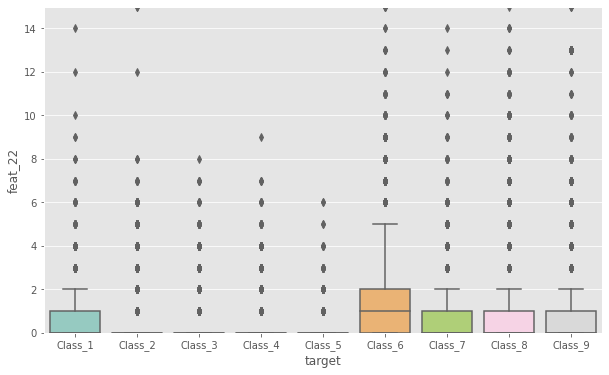

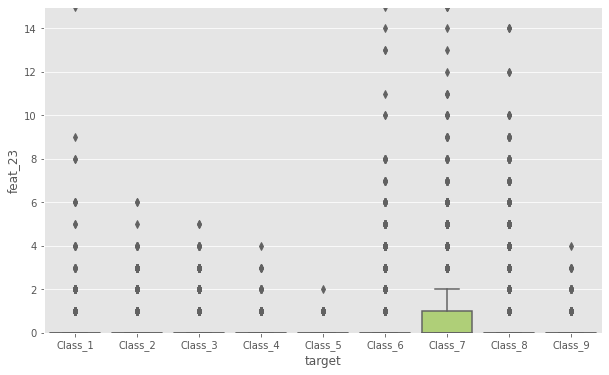

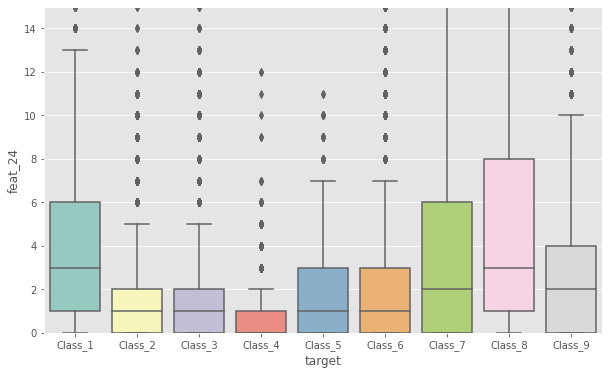

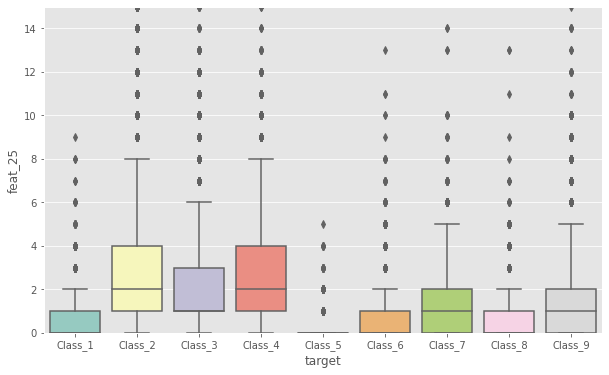

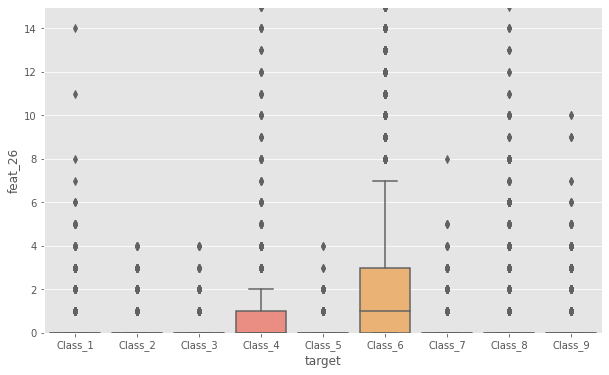

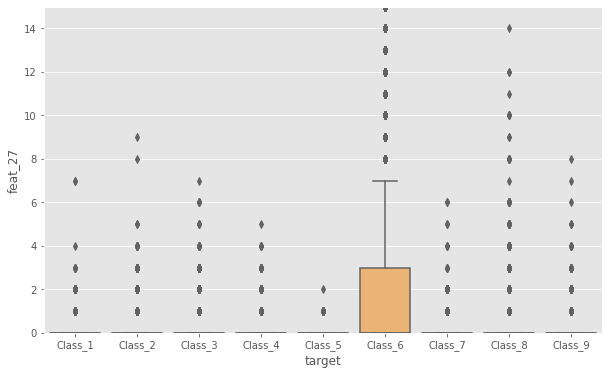

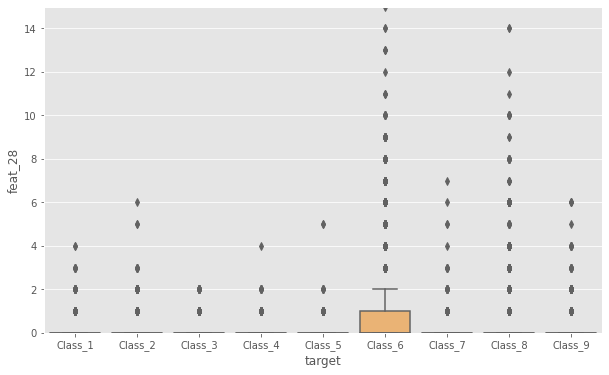

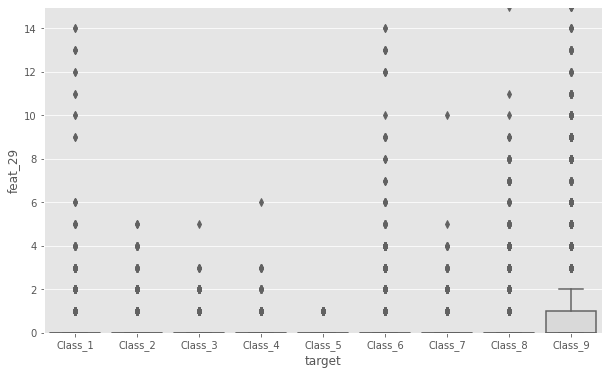

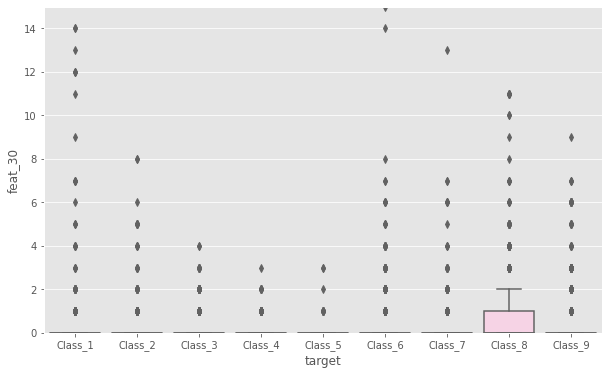

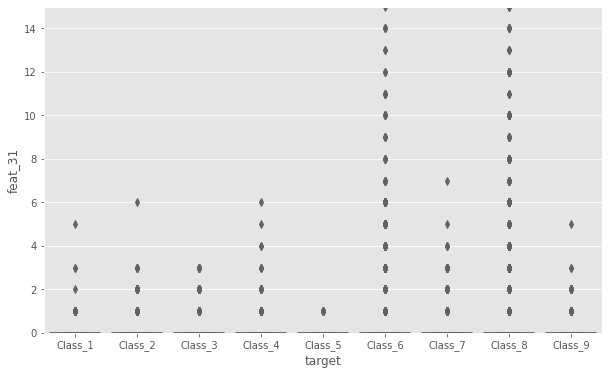

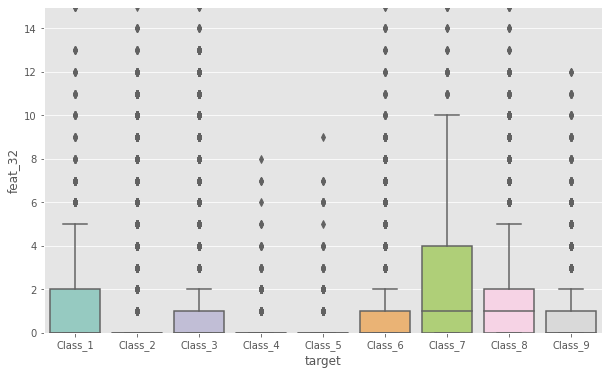

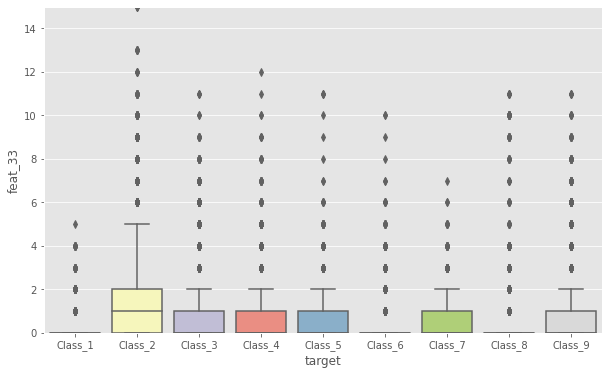

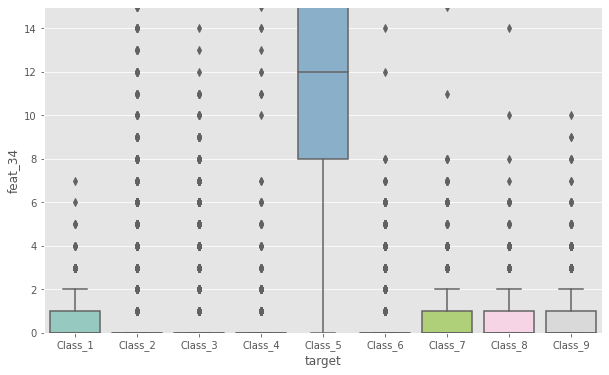

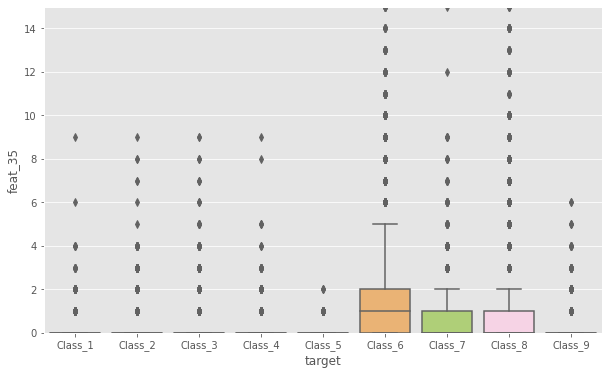

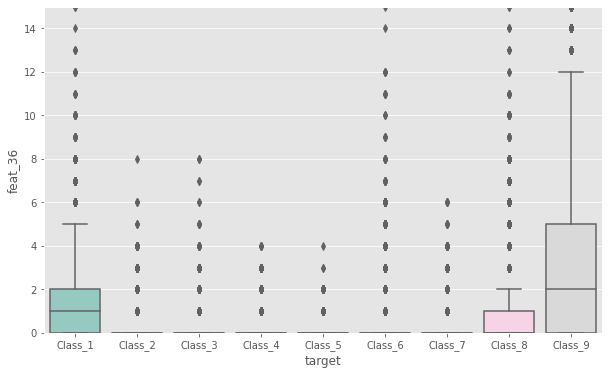

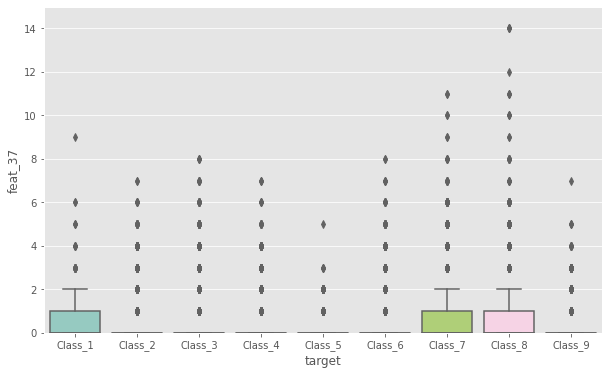

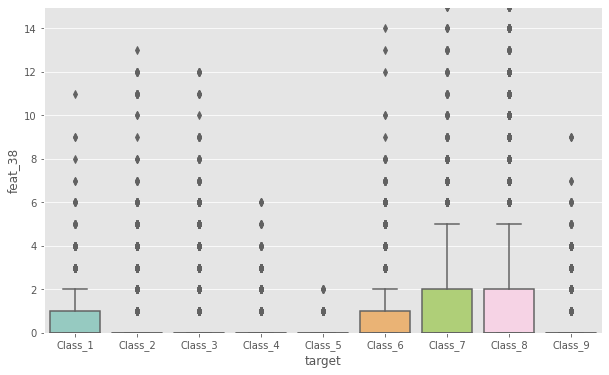

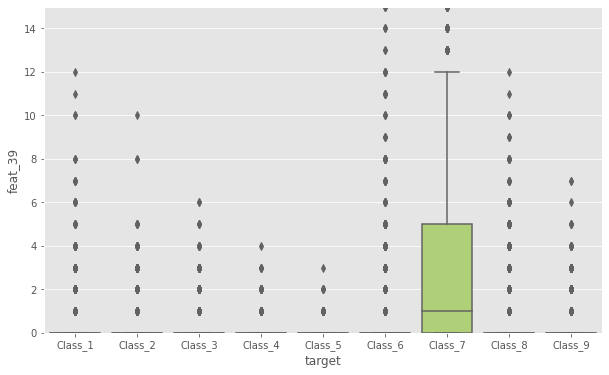

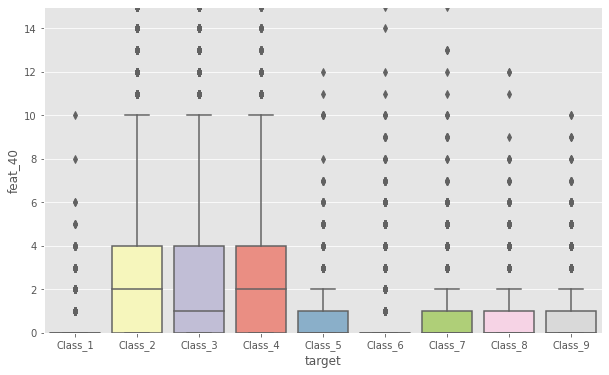

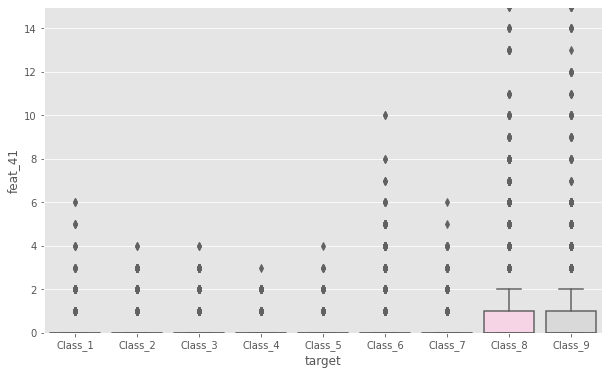

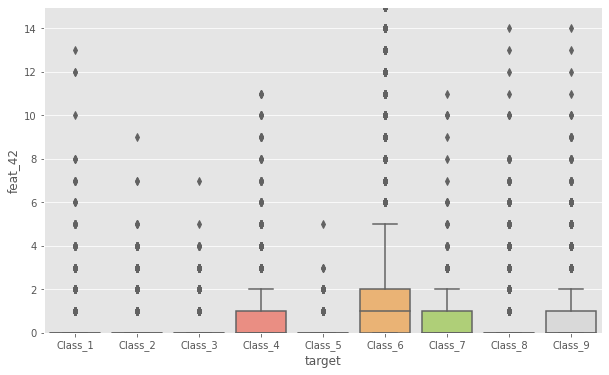

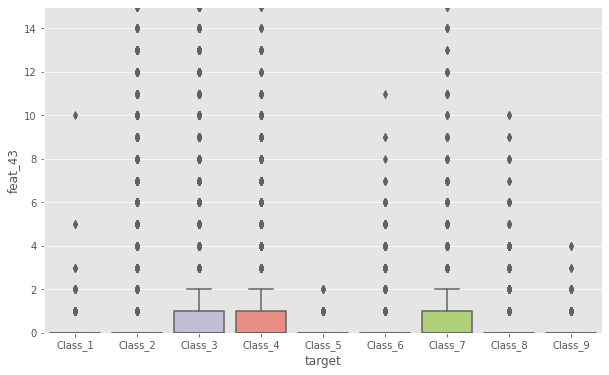

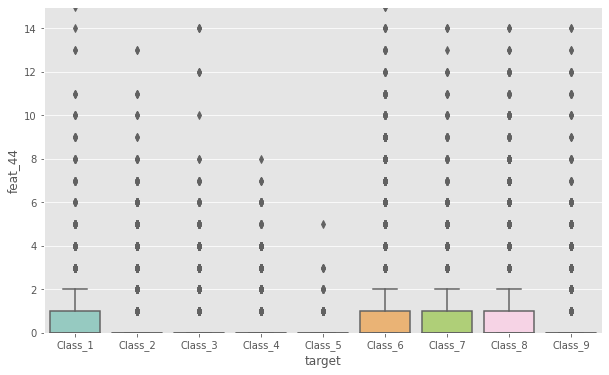

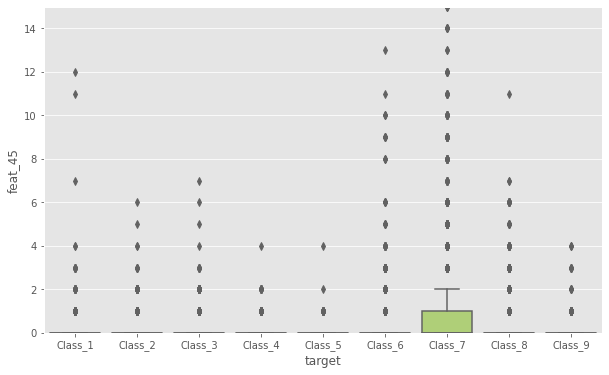

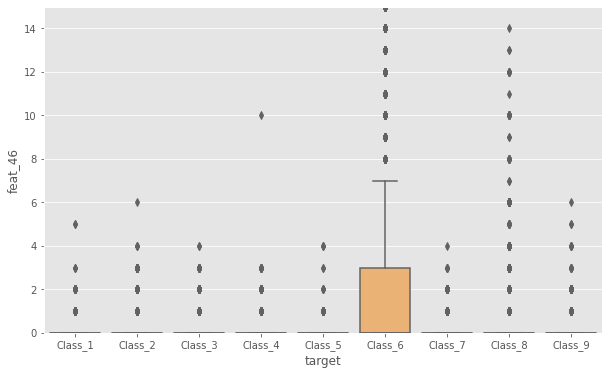

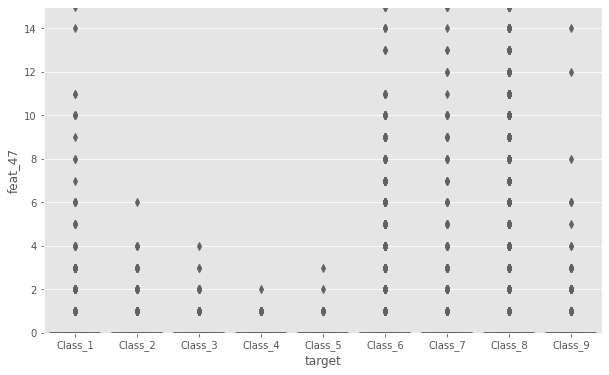

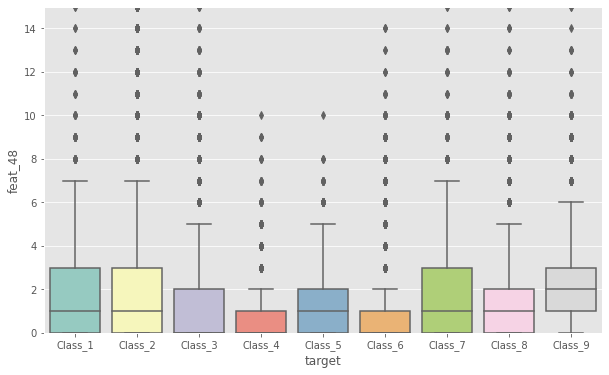

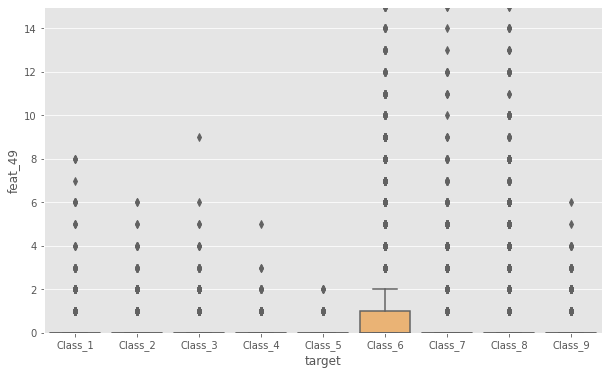

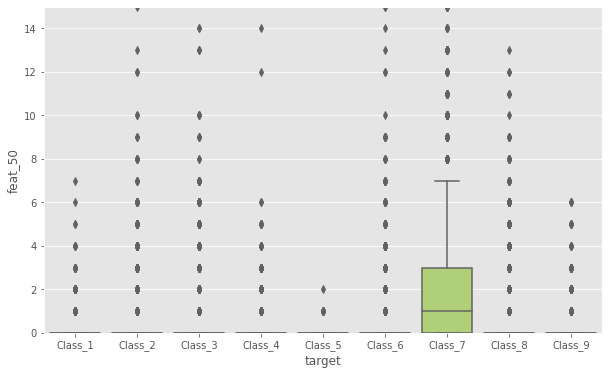

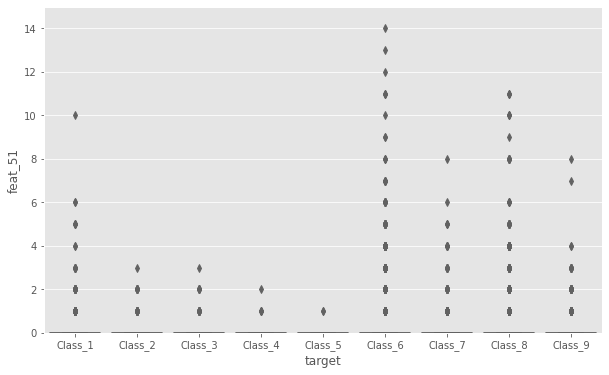

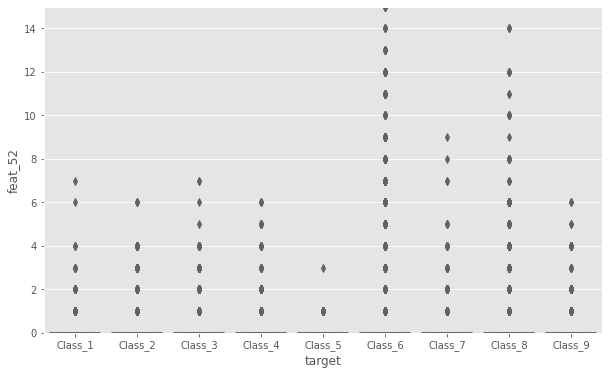

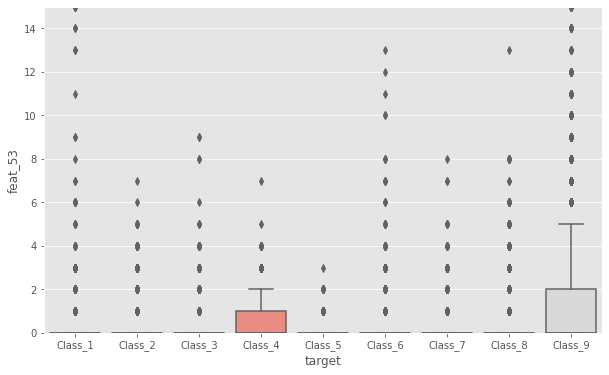

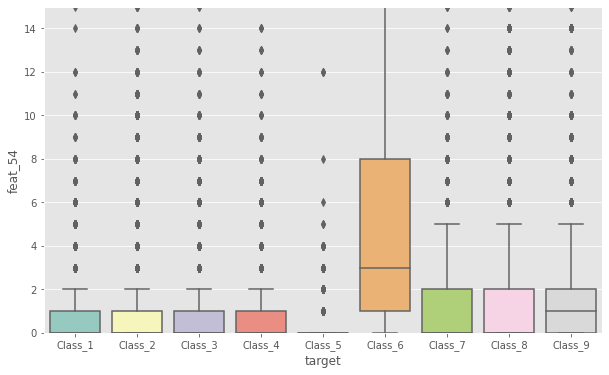

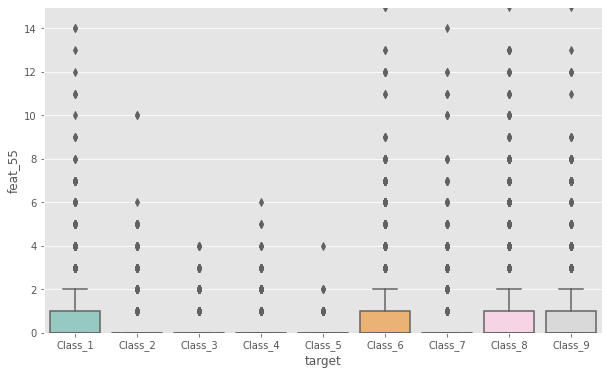

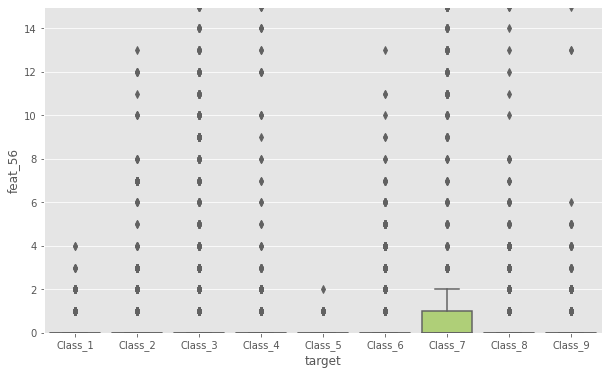

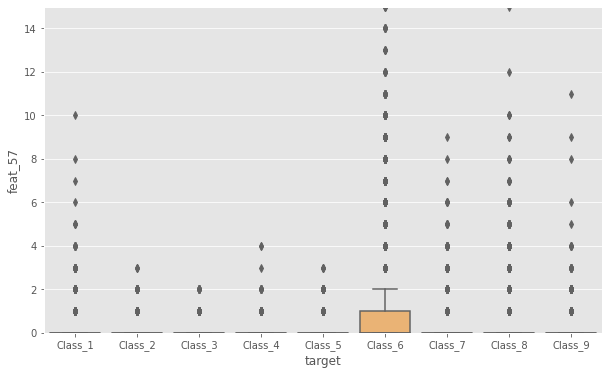

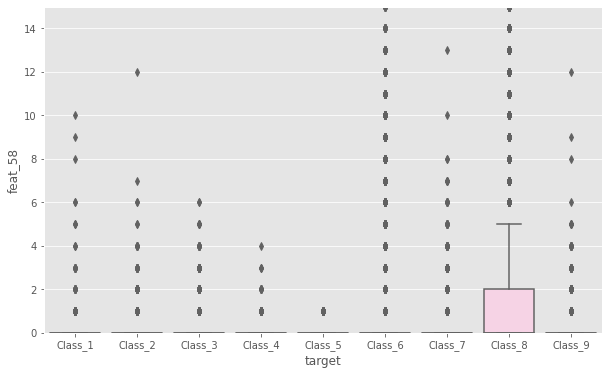

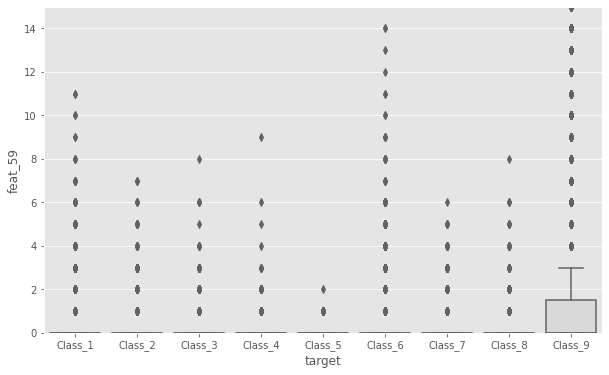

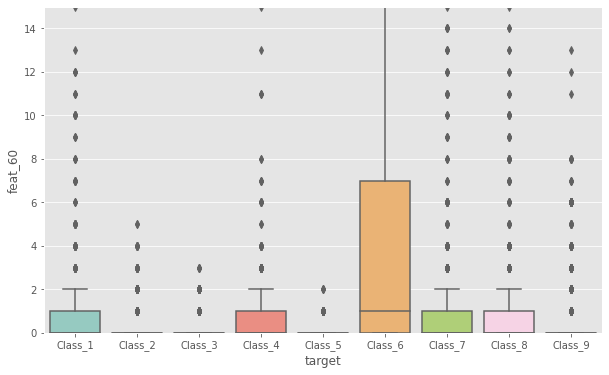

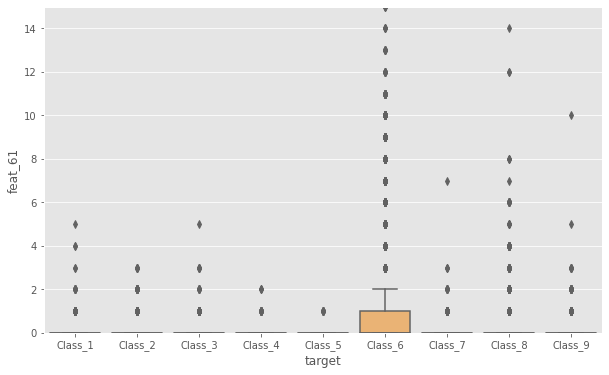

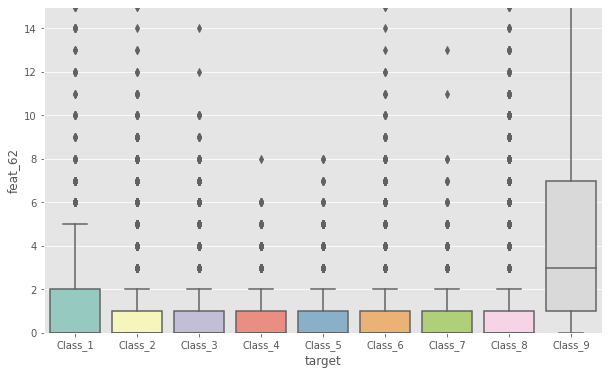

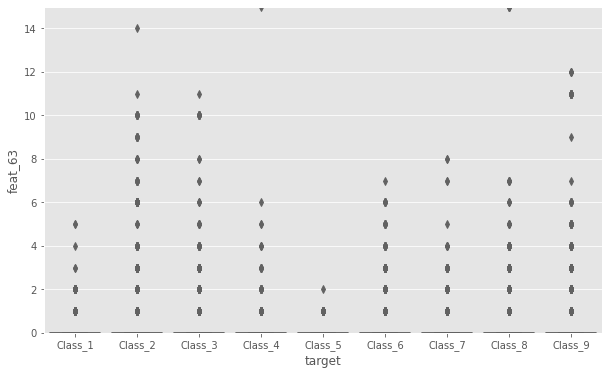

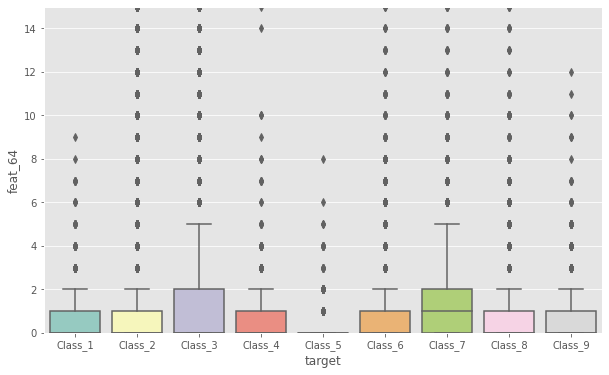

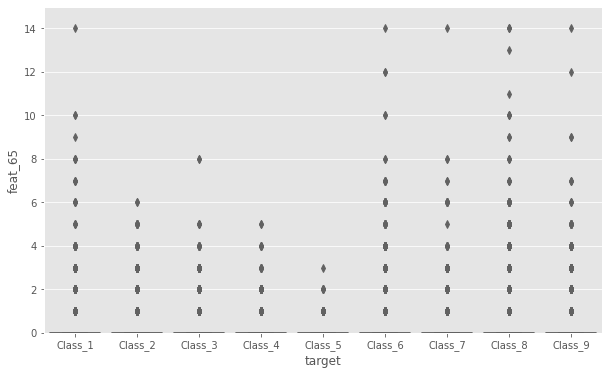

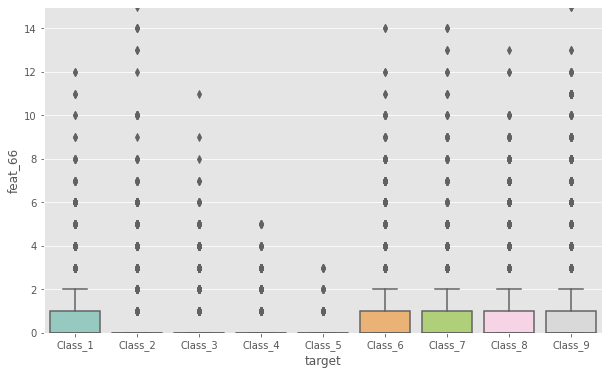

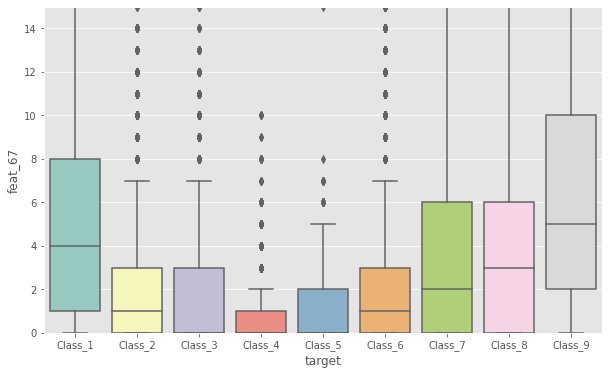

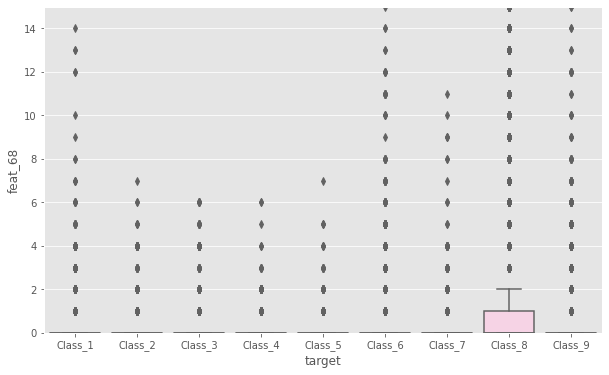

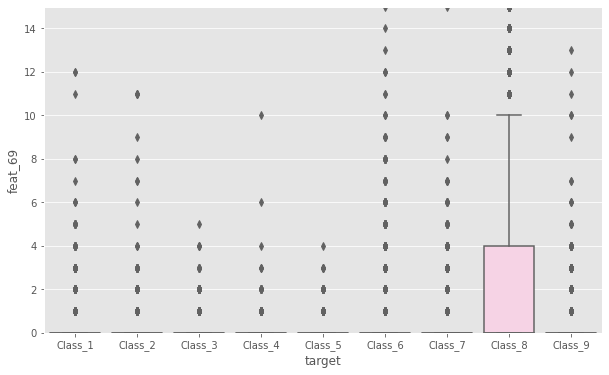

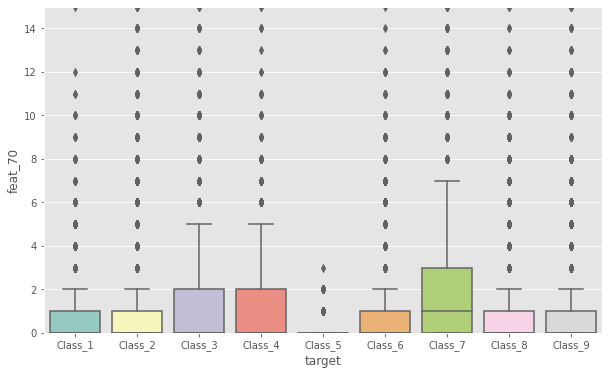

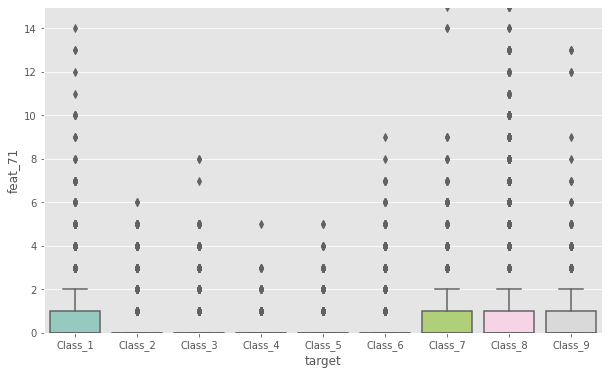

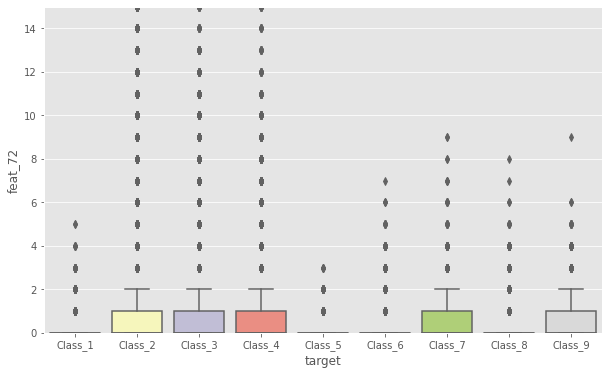

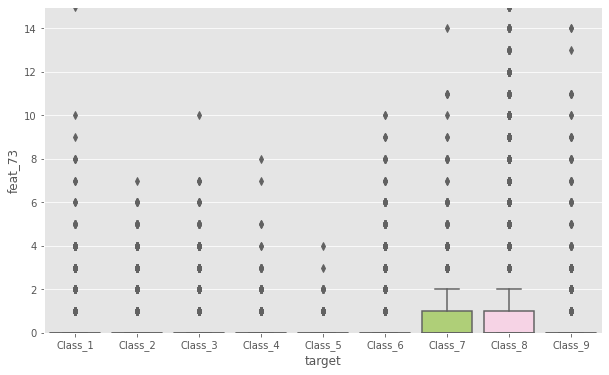

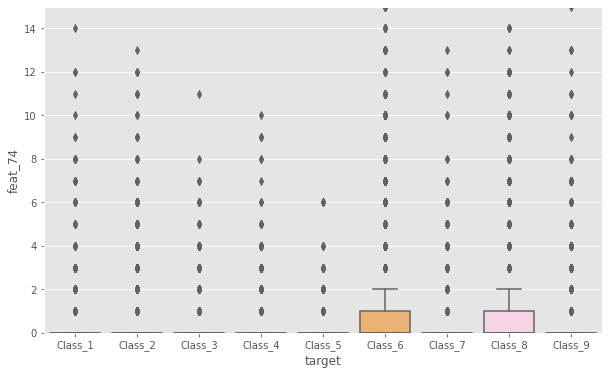

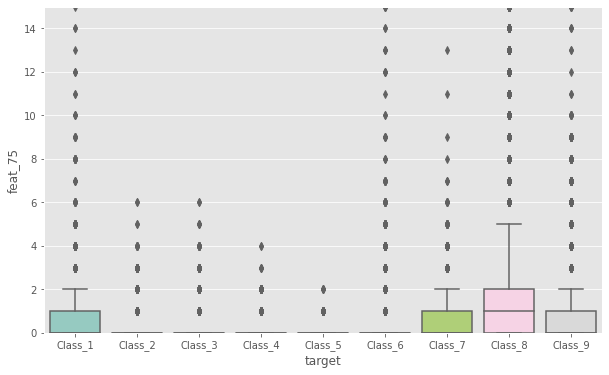

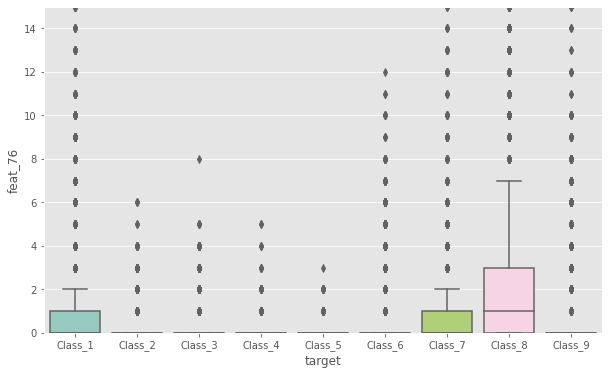

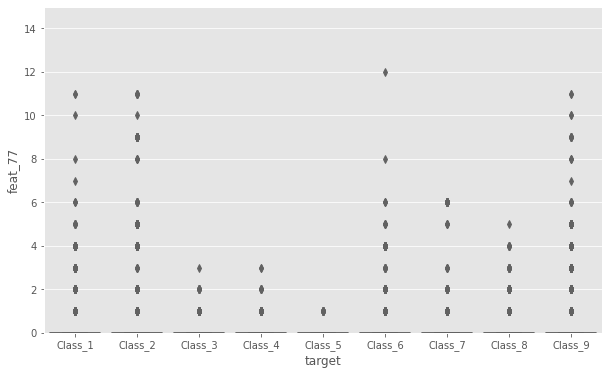

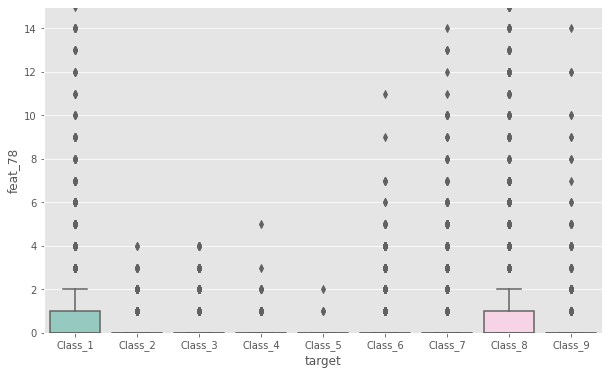

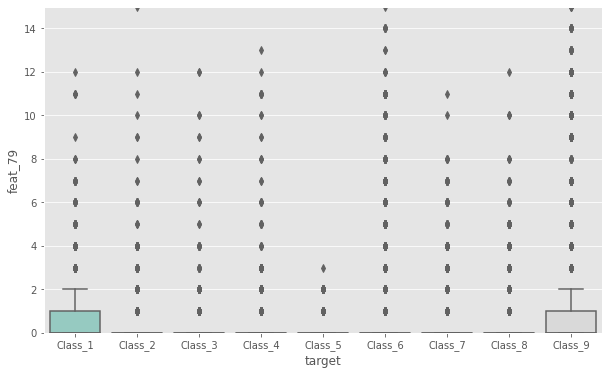

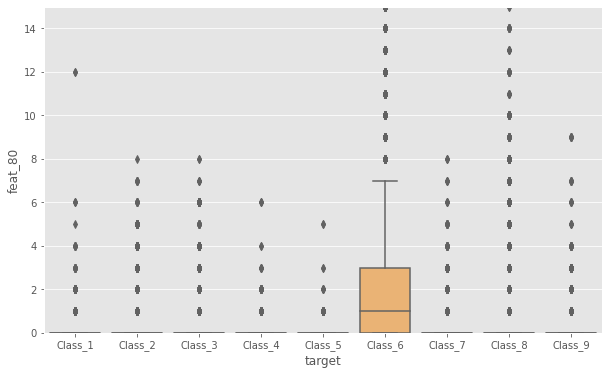

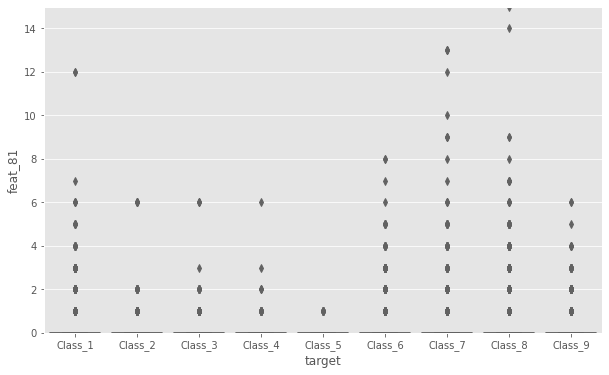

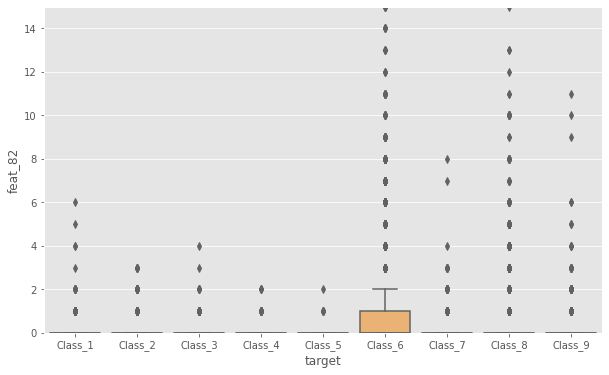

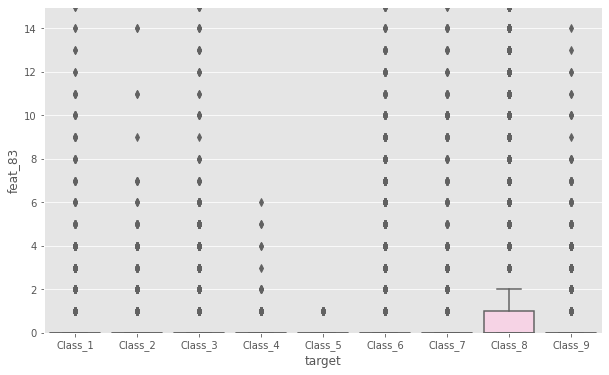

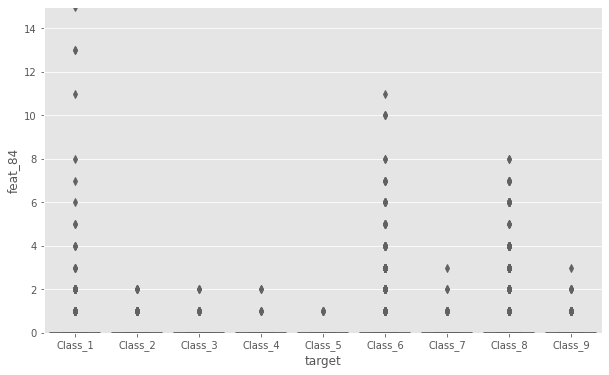

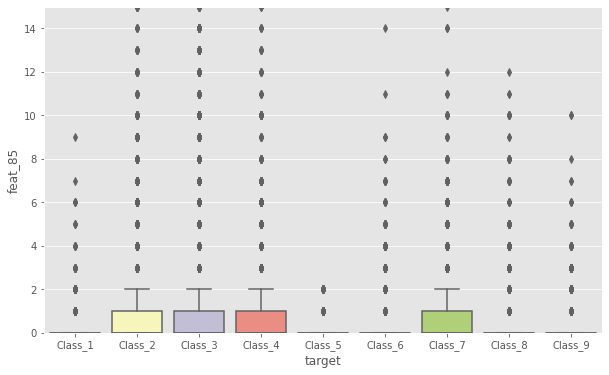

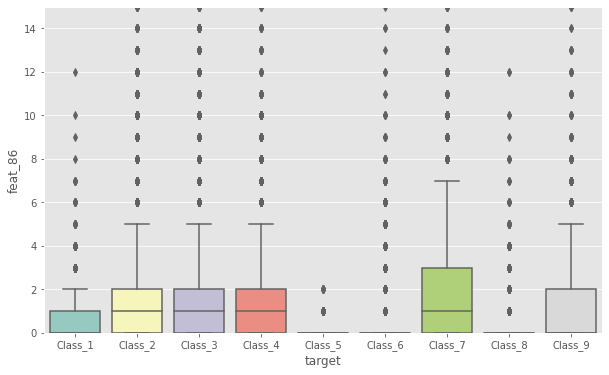

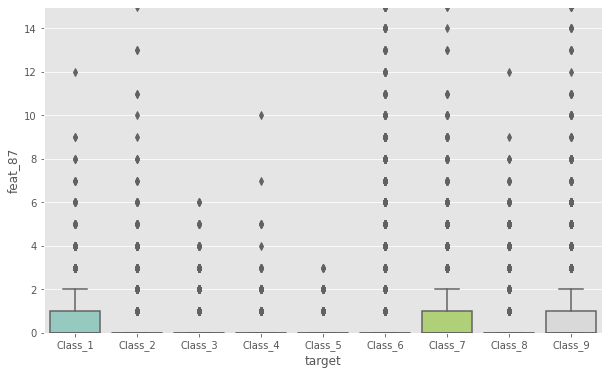

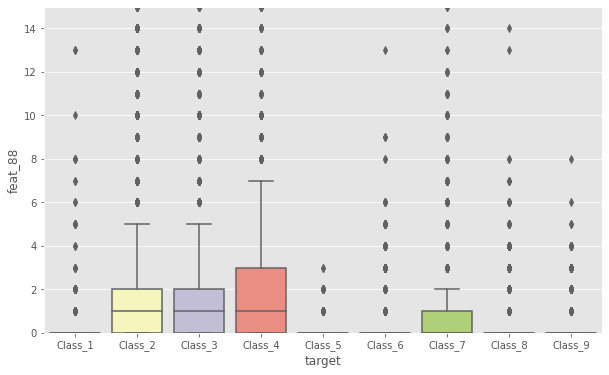

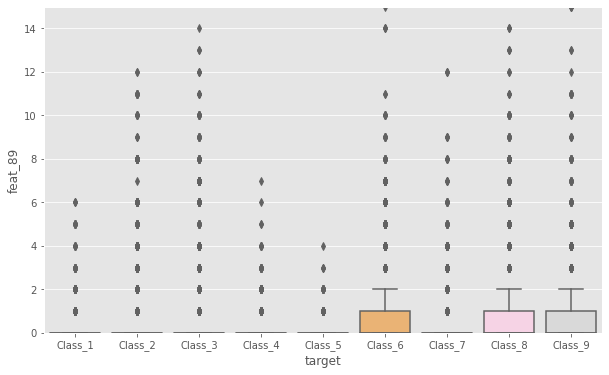

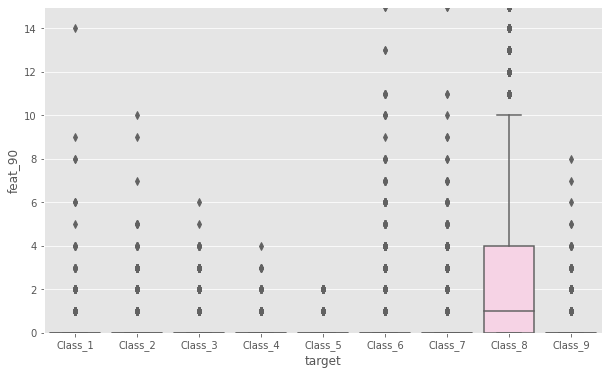

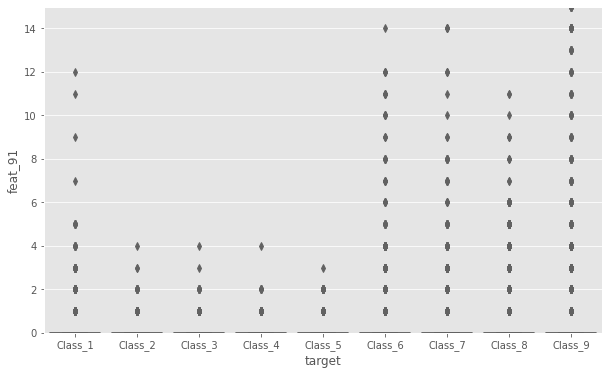

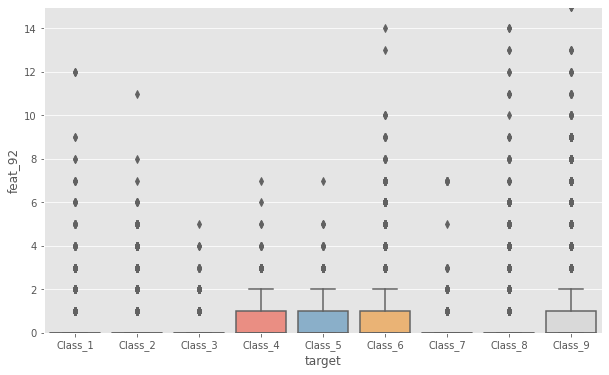

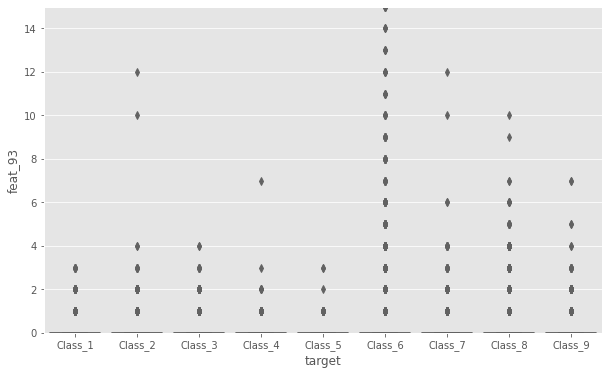

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for name_feat in tqdm(features):
    plt.figure(figsize=(10,6))
    ax = sns.boxplot(x='target', y=name_feat, palette='Set3', data=df_train)
    ax.set_ylim([0, 15])

## Preprocesado de la Base de Datos

Aunque a los árboles no les suele afectar en demasía que las variables tengan diferentes rangos, vamos a tipificar los datos con *Z-Score* por si vamos a usar otros algoritmos **basados en distancias** supervisados, como KNN, o no supervisados, como clústering.

In [8]:
# Estandarizamos las BD
scaler = StandardScaler()
X_train = df_train_reduc[features].values
X_valid = df_valid_reduc[features].values
X_test = df_test_reduc[features].values
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Obtenemos los targets
y_train = df_train_reduc['target_num'].values
y_valid = df_valid_reduc['target_num'].values
y_test = df_test_reduc['target_num'].values

In [9]:
print("Verificamos que las TARGETS estan estratificadas")
print(np.round(np.bincount(y_train)/len(y_train),3))
print(np.round(np.bincount(y_valid)/len(y_valid),3))
print(np.round(np.bincount(y_test)/len(y_test),3))

Verificamos que las TARGETS estan estratificadas
[0.031 0.261 0.129 0.043 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.044 0.044 0.228 0.046 0.137 0.08 ]
[0.031 0.261 0.129 0.043 0.044 0.229 0.046 0.137 0.08 ]


## Modelos Binarios de la Clase 2. Ejemplo con Random Forest

Vamos a desarrollar modelos clasificadores binarios de la clase 2 (Class_2) frente a las otras clases existentes. Para ello, vamos a crear una clase binaria resultado de combinar todas las clases que no son 2 como clase 0, y si es clase 2 como 1. 

In [10]:
y_train_class2 = np.zeros_like(y_train.copy(), dtype=int)
# La clase 2 tiene el valor 1
y_train_class2[y_train==1] = 1
y_valid_class2 = np.zeros_like(y_valid.copy(), dtype=int)
y_valid_class2[y_valid==1] = 1
y_test_class2 = np.zeros_like(y_test.copy(), dtype=int)
y_test_class2[y_test==1] = 1

print('Porcentaje en las tres BD')
print(np.round(np.bincount(y_train_class2)/len(y_train_class2),3))
print(np.round(np.bincount(y_valid_class2)/len(y_valid_class2),3))
print(np.round(np.bincount(y_test_class2)/len(y_test_class2),3))

Porcentaje en las tres BD
[0.739 0.261]
[0.739 0.261]
[0.739 0.261]


### Métrica LogLoss

Inicialmente, vamos a buscar a hacer una exploración rápida con el algoritmo RandomForest que optimice el **logloss()**. 

Esta métrica es una de las métricas más usadas en clasificación.

En clasificación multiclase o multilabel, se define como:

![](https://iryndin.dev/img/logloss.gif)

donde 
- *N* = número de instancias.
- *M* = número de clases.
- $y_{ij}$ = probabilidad real de la clase $j$ correspondiente a la instancia $i$. Suele ser 1 o 0, aunque puede tener cualquier otro valor entre 0 y 1.
- $p_{ij}$ = probabilidad estimada por el clasificador para la clase $j$ de la instancia $i$.

Mientras que en clasificación binaria se suele usar:

![](https://miro.medium.com/max/656/1*wilGXrItaMAJmZNl6RJq9Q.png)

En ambos casos, cuanto más pequeño sea el valor de la métrica, mejor clasificación tendremos.

Vamos a comenzar a estudiar **cómo modelizar el problema usando el algoritmo *RandomForestClassifier()* que es fácil de utilizar, potente y robusto**: . Más adelante, probaremos otros algoritmos más avanzados basados en Gradient Boosting Machines (GBM) como *LightGBM* o *XGBoost*.

  0%|          | 0/9 [00:00<?, ?it/s]

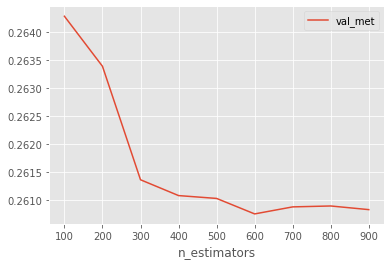

In [ ]:
res = []
for n_estimators in tqdm(np.arange(100, 1000, 100)):
    rf_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=4567)
    rf_model.fit(X_train_scaled, y_train_class2)
    val_met = log_loss(y_valid_class2, rf_model.predict_proba(X_valid_scaled)[:,1])
    res.append(dict(n_estimators=n_estimators, val_met=val_met))
res = pd.DataFrame(res)
res.plot(x='n_estimators', y='val_met')

In [ ]:
best_model = res.iloc[res.val_met.argmin()]
print(best_model)
best_estimators = best_model.n_estimators.astype(int)

# Logloss con la de testeo
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
rf_model.fit(X_train_scaled, y_train_class2)
tst_met = log_loss(y_test_class2, rf_model.predict_proba(X_test_scaled)[:,1])
print("Logloss con la base de datos de testeo=", tst_met)

n_estimators    600.000000
val_met           0.260754
Name: 5, dtype: float64
Logloss con la base de datos de testeo= 0.26022590420620706


### Calibrado de las Probabilidades

Así mismo, podemos ver la diferencia de calibrar las predicciones del clasificador o no. Muchos algoritmos no presentan una probabilidad equilibrada y **cuando se usan métricas del tipo *LogLoss*, es necesario equilibrar la probabilidad de las predicciones**.

Por ejemplo, si el modelo estima una probabilidad del 80% para un caso determinado, el 80% de las predicciones deberían tener una probabilidad menor a esa. Muchos algoritmos que no son probabilisticos como, por ejemplo, los árboles o las máquinas vectores soporte, realizan unas estimaciones de probabilidad que no están equilibradas. 

*scikit-learn* dispone de la función *CalibratedClassifierCV()* que permite calcular un modelo y posteriormente [calibrar las probalidades](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) con [regresión isotónica](https://en.wikipedia.org/wiki/Isotonic_regression) o regresión logística.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_calibration_curve_002.png)

In [14]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    metrica_kappa = cohen_kappa_score(y_valid, preds>0.5)
    metrica_accuracy = accuracy_score(y_valid, preds>0.5, normalize=True)
    metrica_f1=  f1_score(y_valid, preds>0.5)
    metrica_auc = roc_auc_score(y_valid, preds)
    Allmetrics = {'metrica_log_loss': metrica_log_loss,'metrica_kappa':metrica_kappa,'metrica_accuracy':metrica_accuracy,'metrica_f1':metrica_f1,'metrica_auc':metrica_auc}
    return Allmetrics

In [ ]:
%%time
# Comprobamos el grado de generalización del modelo con y sin calibración
rf_model = RandomForestClassifier(n_estimators=best_estimators, n_jobs=-1, random_state=4567)
metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
print(f'Modelo Sin Calibrar LogLossVal={metricas["metrica_log_loss"]}')

metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
print(f'Modelo Con Calibración LogLossVal={metricas["metrica_log_loss"]}')

Modelo Sin Calibrar LogLossVal=0.26022590420620706
Modelo Con Calibración LogLossVal=0.2500473681576325
CPU times: user 59.7 s, sys: 2.8 s, total: 1min 2s
Wall time: 1min 45s


### EJERCICIO 1

Realizar las tareas siguientes y responder en un Informe PDF a las respuestas planteadas:

- Buscar el mejor modelo RF modificando *n_estimators* entre 100 y 1500 (con paso 100) que optimice las siguientes cinco métricas con la base de datos de validación: *Accuracy*, *F1-Score*, *Kappa*, *AUC* y *logloss*. Probar para cada métrica *sin calibrar* y *calibrando*.
- Rellenar **la tabla de abajo con el mejor número de estimadores (calibrando o sin calibrar)** y para cada una de las métricas (presentar el resultado para la base de datos de validación y la de testeo).
- Analizar la tabla y explicar los resultados.
- Explicar **el significado de cada métrica** y analizar por qué funciona mejor un método u otro para cada una de ellas.
- Pon ejemplos de la vida real de cuándo utilizar una métrica u otra.

NOTA: Utilizar la misma semilla aleatoria usada en los ejemplos. Pregunta: ¿Qué pasa si cambiamos la semilla aleatoria?  

    
| Métrica | *n_estimators* | Calibrado | Val | Tst |
|---------|-----------|-----------|-----|-----|
| ACC |700|No|0.8841719642279927|0.05|
| F1  |1300|Si|0.7838072289156627|0.05|
| Kappa |1300|Si|0.7004839743119833|0.05|
| AUC   |1500|No|0.9518383152332526|0.05|
| LogLoss |800|Si|0.24937435870824992 |0.05|


In [ ]:
for num in range(100,1500,100):
  rf_model = RandomForestClassifier(n_estimators=num, n_jobs=-1, random_state=4567)
  metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

  metricas = entrena_model_hold_out(rf_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

Modelo Sin Calibrar LogLossVal=0.26177916511017735 Kappa=0.6896133758963876 Accuracy=0.8822863915526344 F1=0.7684645544134789 AUC=0.9501879297898371
Modelo Con Calibración LogLossVal=0.25160591952347766 Kappa=0.6978651487291327 Accuracy=0.8788923607369895 F1=0.7811952501459997 AUC=0.9495782246217586
Modelo Sin Calibrar LogLossVal=0.2605715017764414 Kappa=0.6951926442162248 Accuracy=0.8840642172179722 F1=0.7729957805907174 AUC=0.9513579937285188
Modelo Con Calibración LogLossVal=0.2503156759277256 Kappa=0.6982054291138242 Accuracy=0.8792156017670509 F1=0.7812682926829267 AUC=0.9498082743334338
Modelo Sin Calibrar LogLossVal=0.26035446092858855 Kappa=0.6949125656642438 Accuracy=0.8839025967029415 F1=0.7728470538631813 AUC=0.9516638103447431
Modelo Con Calibración LogLossVal=0.2498823516881339 Kappa=0.6982193690802914 Accuracy=0.8787307402219589 F1=0.7817317948220693 AUC=0.9500155412532343
Modelo Sin Calibrar LogLossVal=0.2602453753085174 Kappa=0.6947851666494272 Accuracy=0.88395647020795

### EJERCICIO 2

Repetir el ejercicio anterior incluyendo los siguientes algoritmos (tocando solo un hiperparámetro):
- LogisticRegression(*C* = cost)
- KNeighborsClassifier(*n_neighbors* = num_vecinos)
- MLPClassifier(*hidden_layer_sizes* = (num_neuronas,), *solver* = 'lbfgs')
- DecisionTreeClassifier(*max_depth* = max_profundidad)
- SVC(*C*= cost, *kernel*='rbf')


**Rellenar una tabla indicando para cada algoritmo el valor obtenido de la métrica y si ha sido conveniente calibrar o no (entre parentesis).**

| Métrica | RF | LOG | KNN | MLP | DTC | SVC |
|---------|-----|-----|-----|-----|----|-----|
| ACC     |0.8841719642279927(no)|0.8433358474302338 (si)|0.8447365585604999  (no)|0.8635384118090723 (si)|0.8635384118090723 (no)|0.8675250511798298 (si)|
| F1     |0.7838072289156627(si)|0.73224043715847 (si)|0.7493549576115002 (si)|0.7630138176761972 (si)|0.7205253208635957 (si)|0.762942253928468 (si)|
| Kappa     |0.7004839743119833(si)|0.6180389026862254 (si)|0.6475382153493263 (no)|0.6604315254700235 (si)|0.620481046010392 (no)|0.6715987055088828(si)|
| AUC     |0.9518383152332526(no)|0.9144515202900532(si)|0.9309703398175795(si)|0.9421058755878806 (si)|0.9216367232997917(si)|0.9356958222384903(si)|
| LogLoss     |0.24937435870824992(si)|0.314627272432841 (no)|0.29303588687524734 (si)|0.2783941748248958(no)|0.33058446439162237 (si)|0.2892717607050741(si)|


Analiza la tabla y extrae tus propias conclusiones.



In [ ]:
from sklearn.linear_model import LogisticRegression;
for i in [0.0001,0.001,0.01,0.1,1,10]:
  lr_model = LogisticRegression(C=i, n_jobs=-1, random_state=4567)
  metricas = entrena_model_hold_out(lr_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

  metricas = entrena_model_hold_out(lr_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

Modelo Sin Calibrar valor=0.0001 LogLossVal=0.4142822603098077 Kappa=0.21879812138539467 Accuracy=0.7685594224760263 F1=0.30932475884244376 AUC=0.8964783226442499
Modelo Con Calibración valor=0.0001 LogLossVal=0.33845813122476165 Kappa=0.6055960195252597 Accuracy=0.8279280249973063 F1=0.7257898351648352 AUC=0.8973564354608695
Modelo Sin Calibrar valor=0.001 LogLossVal=0.3466186984353539 Kappa=0.4911554740170174 Accuracy=0.8187695291455662 F1=0.606181222196207 AUC=0.9048223074035037
Modelo Con Calibración valor=0.001 LogLossVal=0.3270553523927019 Kappa=0.6180389026862254 Accuracy=0.8363322917789031 F1=0.73224043715847 AUC=0.9056862007453926
Modelo Sin Calibrar valor=0.01 LogLossVal=0.3195210593599821 Kappa=0.5852587238787994 Accuracy=0.8410731602198039 F1=0.6923879040667361 AUC=0.9123613704771921
Modelo Con Calibración valor=0.01 LogLossVal=0.31859319299306377 Kappa=0.6147429681679881 Accuracy=0.8370865208490464 F1=0.728253055355859 AUC=0.9129359863800328
Modelo Sin Calibrar valor=0.1 L

In [ ]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier;
for i in [1,3,5,7,9,11]:
  knn_model = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
  metricas = entrena_model_hold_out(knn_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

  metricas = entrena_model_hold_out(knn_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

Modelo Sin Calibrar valor=1 LogLossVal=5.362673341854935 Kappa=0.5995632596851044 Accuracy=0.8447365585604999 F1=0.7048945320499692 AUC=0.8016278285965838
Modelo Con Calibración valor=1 LogLossVal=0.39281746759855346 Kappa=0.587850858107553 Accuracy=0.8438207089753259 F1=0.6924137931034483 AUC=0.8807560497726805
Modelo Sin Calibrar valor=3 LogLossVal=1.6519990557861532 Kappa=0.6170295065653557 Accuracy=0.8499084150414826 F1=0.7193795326349718 AUC=0.8972142708395704
Modelo Con Calibración valor=3 LogLossVal=0.3211802550008413 Kappa=0.6163050746089371 Accuracy=0.8505548971016055 F1=0.7179174293268255 AUC=0.9191102510136461
Modelo Sin Calibrar valor=5 LogLossVal=0.8553969650053616 Kappa=0.6304756899094013 Accuracy=0.854110548432281 F1=0.7302788844621514 AUC=0.9175703075074384
Modelo Con Calibración valor=5 LogLossVal=0.3032661299108585 Kappa=0.6326877901064649 Accuracy=0.8527098373020149 F1=0.7340466926070038 AUC=0.9266374670355596
Modelo Sin Calibrar valor=7 LogLossVal=0.5803364174588633

In [ ]:
from sklearn.neural_network import MLPClassifier
for i in range(1,13,1):
  mlp_model = MLPClassifier(hidden_layer_sizes = (i,), solver = 'lbfgs', random_state=4567) 
  metricas = entrena_model_hold_out(mlp_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

  metricas = entrena_model_hold_out(mlp_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

Modelo Sin Calibrar valor=1 LogLossVal=0.3148712572686206 Kappa=0.6013212491408526 Accuracy=0.8434435944402543 F1=0.70817433219522 AUC=0.9135499995669387
Modelo Con Calibración valor=1 LogLossVal=0.31997618638095643 Kappa=0.6171105328282583 Accuracy=0.8372481413640771 F1=0.730580576117007 AUC=0.9140931111992298
Modelo Sin Calibrar valor=2 LogLossVal=0.28630367953250146 Kappa=0.6287441899288521 Accuracy=0.8533024458571274 F1=0.7291355814184821 AUC=0.929868466092992
Modelo Con Calibración valor=2 LogLossVal=0.30213272037553424 Kappa=0.6325919149886206 Accuracy=0.8443594440254283 F1=0.7410594245764991 AUC=0.9305022419396929
Modelo Sin Calibrar valor=3 LogLossVal=0.281992147773818 Kappa=0.6234161876704645 Accuracy=0.8548109039974141 F1=0.7216196673897325 AUC=0.9321112568456642
Modelo Con Calibración valor=3 LogLossVal=0.2916465500915128 Kappa=0.6469290556598929 Accuracy=0.8469992457709299 F1=0.7537714582972083 AUC=0.9367886882873477
Modelo Sin Calibrar valor=4 LogLossVal=0.2848051799055506

In [ ]:
from sklearn.tree import DecisionTreeClassifier
for i in range(3,20,1):
  tree_model = DecisionTreeClassifier(max_depth=i, random_state=4567) 
  metricas = entrena_model_hold_out(tree_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

  metricas = entrena_model_hold_out(tree_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')

Modelo Sin Calibrar valor=3 LogLossVal=0.431027534235725 Kappa=0.4255658507254271 Accuracy=0.7999138023919836 F1=0.5491624180626365 AUC=0.814836636085005
Modelo Con Calibración valor=3 LogLossVal=0.41946429301621596 Kappa=0.49035859765407874 Accuracy=0.7909169270552742 F1=0.635210076134975 AUC=0.8545214276864772
Modelo Sin Calibrar valor=4 LogLossVal=0.40407587338757167 Kappa=0.45884233812913133 Accuracy=0.8078332076284883 F1=0.5804023056111045 AUC=0.8405621211419415
Modelo Con Calibración valor=4 LogLossVal=0.3864304377053746 Kappa=0.529829338522712 Accuracy=0.8093416657687749 F1=0.6615016738402677 AUC=0.8757183866168232
Modelo Sin Calibrar valor=5 LogLossVal=0.39436850375987176 Kappa=0.5123408672259393 Accuracy=0.8147290162697985 F1=0.6365845926239037 AUC=0.8665698040265667
Modelo Con Calibración valor=5 LogLossVal=0.3680203876882022 Kappa=0.5408521525702059 Accuracy=0.8242107531516001 F1=0.6592878772058056 AUC=0.8886467360543895
Modelo Sin Calibrar valor=6 LogLossVal=0.3944614582998

In [15]:
from sklearn.svm import SVC
best_log = [];
best_kappa= [];
best_acc=[];
best_f1=[];
best_auc=[];

for i in [0.0001,0.001,0.01,0.1,1,10]:
  svc_model = SVC(C=i, kernel='rbf', probability=True, random_state=4567)
  metricas = entrena_model_hold_out(svc_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=False)
  print(f'Modelo Sin Calibrar valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')
  best_log.append(metricas["metrica_log_loss"]);
  best_kappa.append(metricas["metrica_kappa"]);
  best_acc.append(metricas["metrica_accuracy"]);
  best_f1.append(metricas["metrica_f1"]);
  best_auc.append(metricas["metrica_auc"]);


  metricas = entrena_model_hold_out(svc_model, X_train_scaled, y_train_class2, X_test_scaled, y_test_class2, calibra=True)
  print(f'Modelo Con Calibración valor={i} LogLossVal={metricas["metrica_log_loss"]} Kappa={metricas["metrica_kappa"]} Accuracy={metricas["metrica_accuracy"]} F1={metricas["metrica_f1"]} AUC={metricas["metrica_auc"]}')
  best_log.append(metricas["metrica_log_loss"]);
  best_kappa.append(metricas["metrica_kappa"]);
  best_acc.append(metricas["metrica_accuracy"]);
  best_f1.append(metricas["metrica_f1"]);
  best_auc.append(metricas["metrica_auc"]);

print("Mejores resultados");
print(f'best_log={np.amin(best_log)}');  
print(f'best_kappa={np.amax(best_kappa)}');  
print(f'best_acc={np.amax(best_acc)}');  
print(f'best_f1={np.amax(best_f1)}');  
print(f'best_auc={np.amax(best_auc)}');  


Modelo Con Calibración valor=0.0001 LogLossVal=0.3475051729863499 Kappa=0.585163019906024 Accuracy=0.8325611464281866 F1=0.7006357156617222 AUC=0.8961387649015463
Modelo Con Calibración valor=0.001 LogLossVal=0.34728661824801166 Kappa=0.585216966220707 Accuracy=0.8326150199331969 F1=0.7006455342518548 AUC=0.8962515867932108
Modelo Con Calibración valor=0.01 LogLossVal=0.3440123034901785 Kappa=0.5874138576021801 Accuracy=0.8337463635384118 F1=0.7020084974893781 AUC=0.8983504731477496
Modelo Con Calibración valor=0.1 LogLossVal=0.3252658593664243 Kappa=0.6250358593100458 Accuracy=0.846352763710807 F1=0.7314500941619585 AUC=0.9128549398929698
Modelo Con Calibración valor=1 LogLossVal=0.3025776790058545 Kappa=0.6509986608906204 Accuracy=0.8575045792479259 F1=0.7495976521821452 AUC=0.9282526653042181
Modelo Con Calibración valor=10 LogLossVal=0.2892717607050741 Kappa=0.6715987055088828 Accuracy=0.8675250511798298 F1=0.762942253928468 AUC=0.9356958222384903
Mejores resultados
best_log=0.2892

## Balanceo de Clases

Algunas métricas pueden mejorarse mediante el balanceo de las clases que consiste en **equilibrar el número de casos de cada clase**:

- Sobremuestreando la clase minoritaria (*oversampling*).
- Submuestrando la clase mayoritaria (*subsampling*).
- Creando nuevos casos de la clase minoritaria mediante algoritmos como SMOTE.

ref1: https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data/notebook

Otra forma, más habitual y eficiente, **es aplicar diferentes pesos a cada una de las clases**, de forma que la clase minoritaria tenga mayor peso que la mayoritaria a la hora de construir el modelo (habitualmente la función *loss* del algoritmo incorpora los pesos de cada clase en la propia fórmula de modo que el balanceo se realiza directamente al calcular dicho coste).

Vamos a ver un ejemplo para mejora el *accuracy*. Como se puede ver en la gráfica, la base de datos está desbalanceada.

False    18303
True      6449
Name: is_class_2, dtype: int64

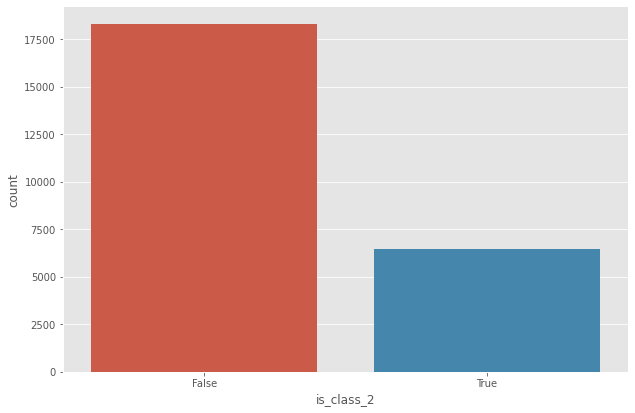

In [ ]:
X_tmp = df_train_reduc.copy()
X_tmp['is_class_2'] = (y_train_class2==1)
g = sns.catplot(x='is_class_2', data=X_tmp, kind='count')
g.fig.set_size_inches(10,6)
X_tmp['is_class_2'].value_counts()

In [ ]:
def entrena_model_hold_out(model, X_train, y_train, X_valid, y_valid, calibra=True):
    np.random.seed(4567)
    if calibra:
        calibrated_clf = CalibratedClassifierCV(model, method='isotonic', cv=5)
        calibrated_clf.fit(X_train, y_train_class2)
        preds = calibrated_clf.predict_proba(X_valid)[:,1]
    else:
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:,1]
    metrica_log_loss = log_loss(y_valid, preds, eps=1e-15, normalize=True)
    metrica_acc = accuracy_score(y_valid, preds>0.50)
    return dict(log_loss=metrica_log_loss, acc=metrica_acc)

Vamos a probar Balancear las clases con la librería *imblearn* usando el modelo Logistico. 

**Es importante entender que la base de datos de validación y testeo NO hay que modificarlas, solo la de entrenamiento. Si modificamos las bases de datos de validación o testeo estamos desvirtuando toda la validación de los modelos**

In [ ]:
# !python -m pip install imblearn

In [ ]:
log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_scaled, y_train_class2, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico Sin Balancear ACC={metricas["acc"]}')

Modelo Logistico Sin Balancear ACC=0.839258780435251


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303 18303]
Modelo Logistico con OverSampling ACC=0.8198664081017022


In [ ]:
oversamp = RandomUnderSampler(random_state=1234)
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con UnderSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [6449 6449]
Modelo Logistico con UnderSampling ACC=0.818304244774833


Vemos que parece que NO mejora el ACC con ninguno de los dos. Quizás balancear al 100% las clases es demasiado y puede ser interesante hacer un balanceo con un ratio que no sea del 100%. Para ello se puede usar la opción *sampling_strategy* que permite indicar el número de casos de cada clase que queremos que muestree.

Incrementamos levemente el número de casos de la clase 2 (clase minoritaria)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
oversamp = RandomOverSampler(random_state=1234, sampling_strategy={0:18303, 1:6500})
X_train_resampled, y_train_resampled = oversamp.fit_resample(X_train_scaled, y_train_class2)
print('Numero de casos de cada clase:', np.bincount(y_train_resampled))

log_model = LogisticRegression(C=1, random_state=1234, n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico con un ligero OverSampling ACC={metricas["acc"]}')

Numero de casos de cada clase: [18303  6500]
Modelo Logistico con un ligero OverSampling ACC=0.8393126481361776


Existen otros métodos como SMOTE que permite realizar nuevas instancias de la clase minoritaria en base a búsqueda por K-Vecinos (ver ejemplos en https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).


Otra forma, muy utilizada e incluso más eficiente, es la del siguiente ejemplo donce vemos otra forma de tratar el desbalanceo mediante el uso de pesos diferentes para cada clase.        

In [ ]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
print('Pesos asignados a cada clase:',len(y_train_class2)/(2*np.bincount(y_train_class2)))
log_model = LogisticRegression(C=1, class_weight='balanced',random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Pesos asignados a cada clase: [0.6761733  1.91905722]
Modelo Logistico ajustando los Pesos ACC=0.8197048049989226
CPU times: user 78.6 ms, sys: 81.9 ms, total: 160 ms
Wall time: 3.59 s


Igual que en el caso anterior, los pesos pueden ser ajustados manualmente para que el balanceo sea menos drástico.

In [ ]:
%%time
# Se asigna un peso a cada clase inversamente proporcional a la fecuencia de cada clase
log_model = LogisticRegression(C=1, class_weight={0:0.6761, 1:0.7}, random_state=4567,n_jobs=-1)
metricas = entrena_model_hold_out(log_model, X_train_resampled, y_train_resampled, X_valid_scaled, y_valid_class2, calibra=False)
print(f'Modelo Logistico ajustando los Pesos ACC={metricas["acc"]}')

Modelo Logistico ajustando los Pesos ACC=0.8393665158371041
CPU times: user 75.9 ms, sys: 77.3 ms, total: 153 ms
Wall time: 3.92 s


### EJERCICIO  3

Elige el mejor algoritmo para cada una de las métricas obtenidas en la tabla del ejercicio 2 e intenta mejorar los resultados obtenidos con alguna de las técnicas de muestreo anteriores. Rellena la siguiente tabla.



| Métrica | Algoritmo | Original | Nuevo | Método Usado |
|---------|-----------|----------|-------|--------------|
| ACC     |MLP|0.00|0.05|Undersampling|
| F1     |SVC|0.00|0.05|Smote|
| Kappa     |LOG|0.00|0.05|Undersampling (0=10000,1=7000)|
| AUC     |DTC|0.00|0.05|Oversampling|
| LogLoss     |MLP|0.00|0.05|No se ha podido|

## ENTREGA

**Todos los pasos realizados deberán ser explicados con detalle en un documento PDF. El nombre del archivo deberá incluir lo siguiente 'PROYECTO3_NombreDelAlumnoSinAcentos.PDF'. Ejemplo: PROYECTO3_PEPITO_PEREZ.PDF**

Si usas Colab, recuerde guardar sus cambios en su repositorio utilizando la opción "Save a copy in GitHub..." del menú File.